# Herramientas de Econometría: Clase 3 - Series de tiempo

In [1]:
from pandas import read_csv
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.ndimage.interpolation import shift
import statsmodels.tsa.api as smtsa
import statsmodels.api as sm
import statsmodels.stats as smst
import statsmodels.stats.api as sms
from statsmodels.tsa.statespace.sarimax import SARIMAX
import random
random.seed(123)
%matplotlib inline

## Conceptos básicos

### Componentes de una serie de tiempo

* Tendencia
* Estacionalidad
* Ciclo
* Componente irregular

In [73]:
df = pd.read_csv('airline-passengers.csv')
df['Month'] = pd.to_datetime(df['Month'], format = '%Y-%m')#.dt.strftime('%Y-%m')
df = df.set_index('Month')

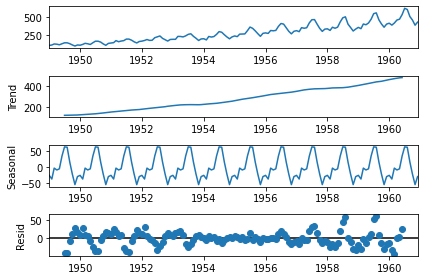

In [74]:
# Aditivo
result = seasonal_decompose(df, model='aditive')
result.plot()
plt.show()

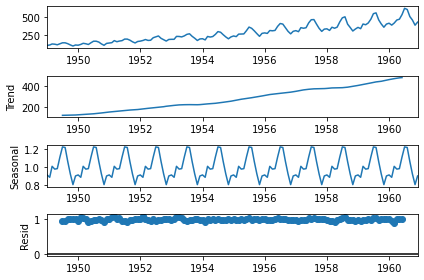

In [75]:
# Multiplicativo
result = seasonal_decompose(df, model='multiplicative')
result.plot()
plt.show()

### Ruido blanco

$E(\varepsilon_t) = 0$

$E(\varepsilon_t ^2) = \sigma^2$

$E(\varepsilon_t \varepsilon_k) = 0$                $\forall t,k$

In [76]:
ruido_blanco = np.random.normal(loc=0.0, scale=1., size=100)

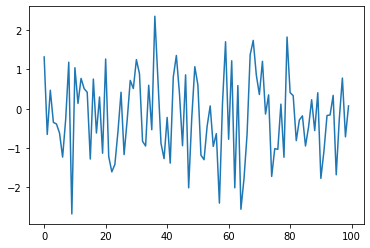

In [77]:
plt.plot(ruido_blanco)
plt.show()

### Caminata aleatoria

$y_t = y_{t-1}+\varepsilon_t$

In [78]:
caminata_aleatoria = np.cumsum(ruido_blanco)

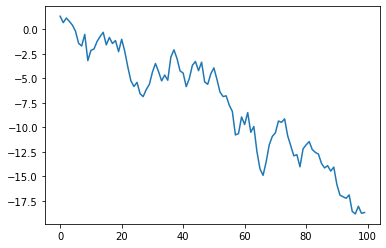

In [79]:
plt.plot(caminata_aleatoria)
plt.show()

### Retardos (lags)

$y_{t-j}  =  L^j y_{t}$

In [80]:
# Con scipy
y_t = ruido_blanco
y_t_1 =shift(caminata_aleatoria, 1, cval=np.NaN)
y_t_2 =shift(caminata_aleatoria, 2, cval=np.NaN)
y_t_3 =shift(caminata_aleatoria, 3, cval=np.NaN)
y_t_4 =shift(caminata_aleatoria, 4, cval=np.NaN)
y_t_5 =shift(caminata_aleatoria, 5, cval=np.NaN)

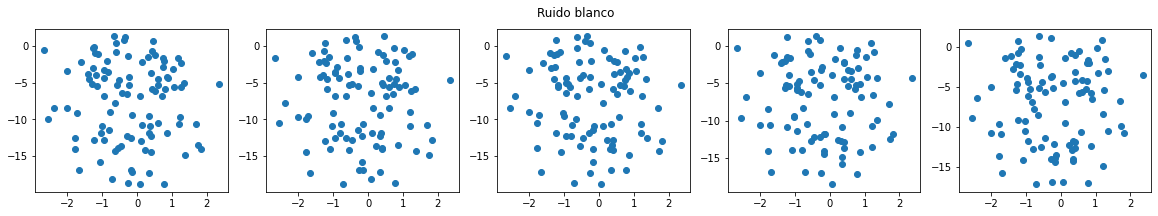

In [81]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20,3))
fig.suptitle('Ruido blanco')
ax1.scatter(y_t, y_t_1)
ax2.scatter(y_t, y_t_2)
ax3.scatter(y_t, y_t_3)
ax4.scatter(y_t, y_t_4)
ax5.scatter(y_t, y_t_5)
plt.show()

In [82]:
# Con pandas
def my_lag_plot(serie, titulo):
    s = pd.Series(serie)
    y_t = s
    y_t_1 =s.shift(1)
    y_t_2 =s.shift(2)
    y_t_3 =s.shift(3)
    y_t_4 =s.shift(4)
    y_t_5 =s.shift(5)
    
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20,3))
    fig.suptitle(titulo, fontsize = 14, fontweight = "bold")
    ax1.scatter(y_t, y_t_1)
    ax2.scatter(y_t, y_t_2)
    ax3.scatter(y_t, y_t_3)
    ax4.scatter(y_t, y_t_4)
    ax5.scatter(y_t, y_t_5)
    plt.show()
    

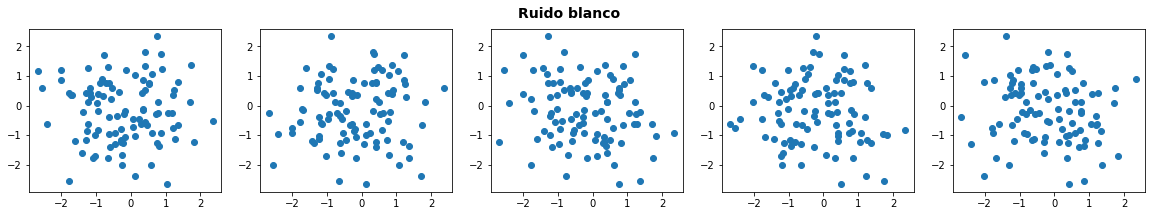

In [83]:
my_lag_plot(ruido_blanco, 'Ruido blanco' )

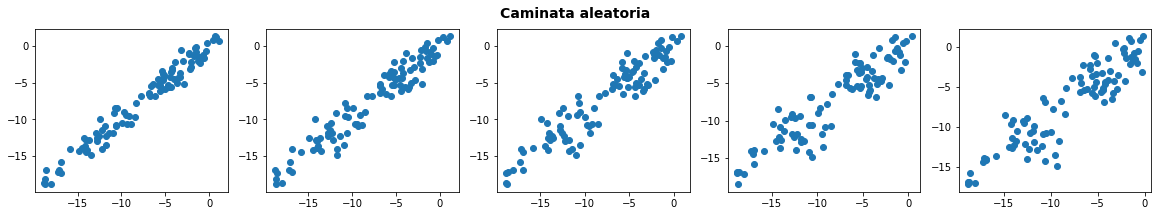

In [84]:
my_lag_plot(caminata_aleatoria, 'Caminata aleatoria' )

### Tomar diferencias

Diferencia de primer orden: $\Delta y_t  =  y_{t} - y_{t-1} =(1-L)y_t $

Diferencia de segundo orden: $\Delta ^2 y_t = \Delta (\Delta y_t) = \Delta(y_t - y_{t-1})= (y_t - y_{t-1}) - (y_{t-1} - y_{t-2}) = y_t -2 y_{t-1} + y_{t-2} \neq y_{t} - y_{t-2}$

Veamos qué pasa si diferenciamos a una caminata aleatoria:

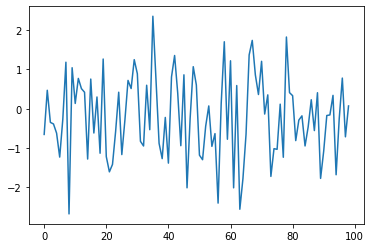

In [85]:
# Con numpy
primera_diferencia = np.diff(caminata_aleatoria)

plt.plot(primera_diferencia)
plt.show()

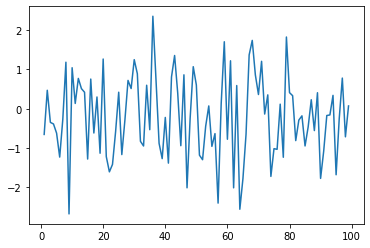

In [86]:
# Con pandas
s= pd.Series(caminata_aleatoria)
primera_dif = s.diff(1)
plt.plot(primera_dif)
plt.show()

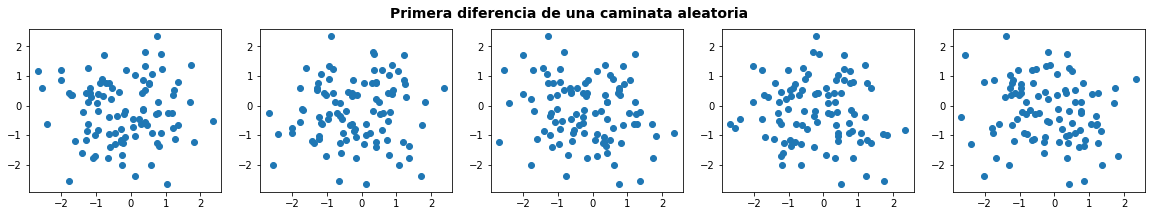

In [87]:
my_lag_plot(primera_dif, 'Primera diferencia de una caminata aleatoria')

Claro, la primera diferencia de una caminata aleatoria (PURA) es un ruido blanco.

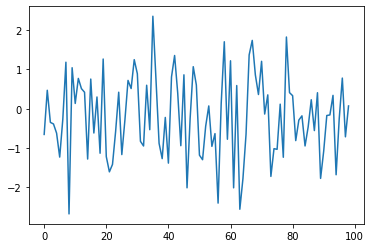

In [88]:
plt.plot(primera_diferencia)
plt.show()

### Algunos aprendizajes

* La caminata aleatoria es no estacionaria, pero si se la diferencia se obtiene un ruido blanco, que es estacionario. Entonces se dice que es integrada de orden uno $I(1)$.
* La correlación entre la caminata aleatoria y sus retardos decae muy lentamente.
* En un ruido blanco la autocorrelación siempre es cero.

### Función de autocorrelación (ACF)

$\rho_j = \frac{\gamma_j}{\gamma_0} = \frac{ E\left[(y_t - \mu) (y_{t-j} - \mu) \right]}{E\left[(y_t - \mu)^2 \right]}$

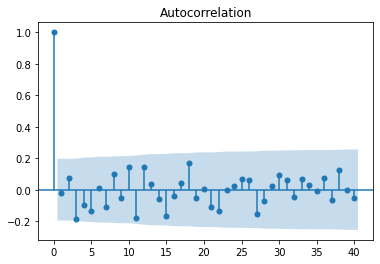

In [89]:
sm.graphics.tsa.plot_acf(ruido_blanco, lags=40)
plt.show()

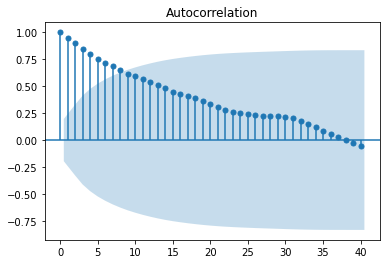

In [90]:
sm.graphics.tsa.plot_acf(caminata_aleatoria, lags=40)
plt.show()

### Función de autocorrelación parcial (PACF)

$\alpha_{jj}$ tal que:

$y_t = \alpha_{j1} y_{t-1}+\alpha_{j2} y_{t-2}+...+\alpha_{jj} y_{t-j}+\varepsilon_t$

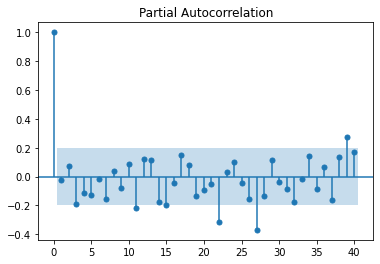

In [91]:
sm.graphics.tsa.plot_pacf(ruido_blanco, lags=40)
plt.show()

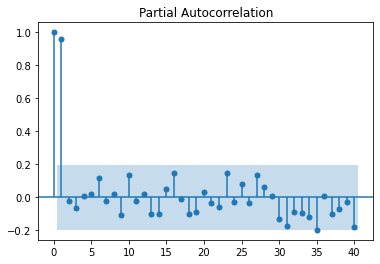

In [92]:
sm.graphics.tsa.plot_pacf(caminata_aleatoria, lags=40)
plt.show()

Creemos una función para simplificar la generación de correlogramas:

In [93]:
def my_ts_plot(serie, titulo):
    fig = plt.figure()
    fig.set_figheight(8)
    fig.set_figwidth(8)

    fig.suptitle(titulo, fontsize = 14, fontweight = "bold")
    plt.subplots_adjust(top = 0.95) 
    ax0 = plt.subplot2grid(shape=(2, 2), loc=(0, 0), colspan=2)
    ax1 = plt.subplot2grid(shape=(2, 2), loc=(1, 0), colspan=1)
    ax2 = plt.subplot2grid(shape=(2, 2), loc=(1, 1), rowspan=1)

    ax0.plot(serie)
    sm.graphics.tsa.plot_acf(serie, lags=40, ax=ax1)
    sm.graphics.tsa.plot_pacf(serie, lags=40, ax=ax2)

    plt.show()

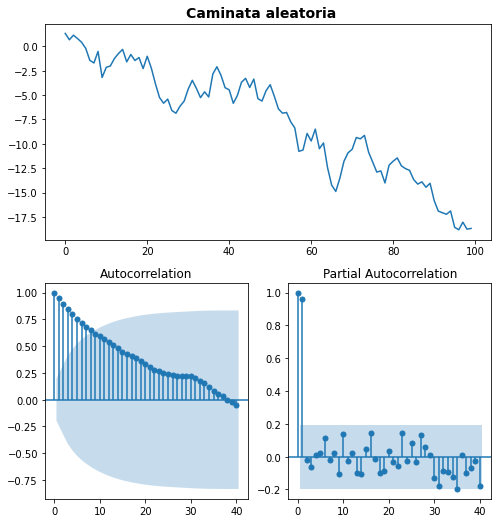

In [94]:
my_ts_plot(caminata_aleatoria, 'Caminata aleatoria')

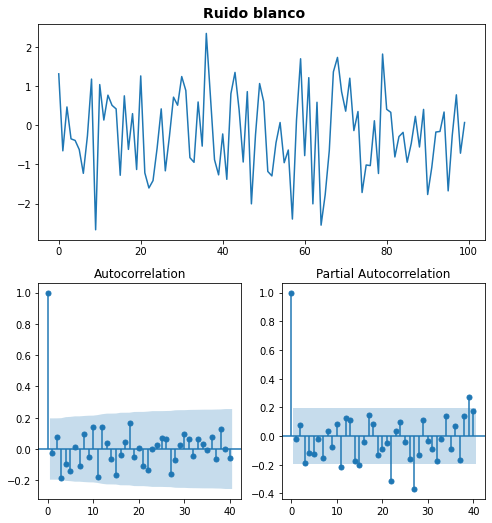

In [95]:
my_ts_plot(ruido_blanco, 'Ruido blanco')

## ARMA

Los modelos ARMA son estacionarios. Su formulación es:

$y_t = c +\phi_1 y_{t-1}+ ...+\phi_p y_{t-p} - \theta_1 \varepsilon_{t-1} - \theta_2 \varepsilon_{t-2} +...+ \theta_q \varepsilon_{t-q}+ \varepsilon_{t}$

o sea que incorporan retardos de la variable $y_t$ y del error.

En forma mas abreviada, se pueden escribir como:

$\phi(L) y_t =c +\theta(L)\varepsilon_{t}$

### AR(1)

$y_t = c + \phi_1 y_{t-1}+ \varepsilon_t$

$\phi(L) y_t = (1 - \phi_1 L )y_t = c+ \varepsilon_t$

In [96]:
#Simulación de un AR(1)
n = 300
ar = np.r_[1, -0.8]
ma = np.r_[1, 0]
ar1 = smtsa.arma_generate_sample(ar=ar, ma=ma, nsample=n)

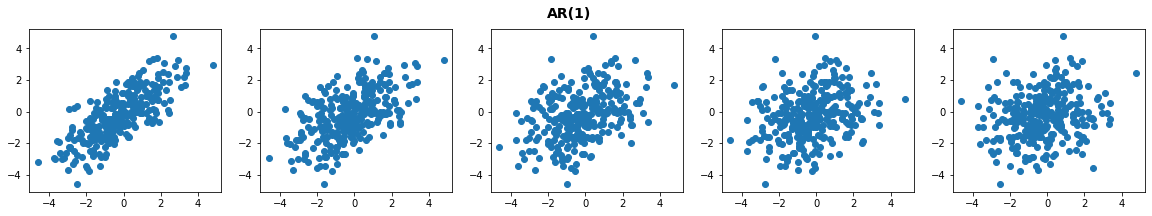

In [97]:
my_lag_plot(ar1, 'AR(1)')

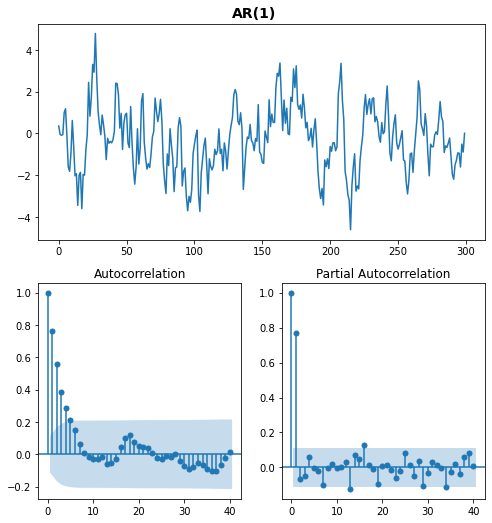

In [98]:
my_ts_plot(ar1, 'AR(1)')

* El decaimiento de la ACF es lento, pero no tanto como en el caso de la caminata aleatoria.
* La PACF decae en forma abrupta después del lag 1.

ACF: $\rho_j = \phi_1^j$

PACF: $\alpha_{11} = \phi_1$ ; $\alpha_{jj} = 0$   $\forall j\geq 1$

### AR(3)

$y_t =  c + \phi_1 y_{t-1}+\phi_2 y_{t-2}+\phi_3 y_{t-3} + \varepsilon_t$

$\phi(L) y_t = (1 - \phi_1 L - \phi_2 L^2 -\phi_3 L^3 )y_t  = c+ \varepsilon_t$

In [99]:
#Simulación de un AR(3)
n = 300
ar = np.r_[1, 0.6, 0.7, 0.8]
ma = np.r_[1, 0]
ar3 = smtsa.arma_generate_sample(ar=ar, ma=ma, nsample=n)

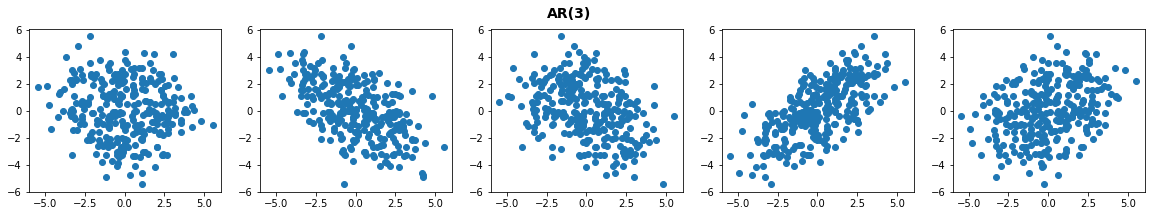

In [100]:
my_lag_plot(ar3, 'AR(3)')

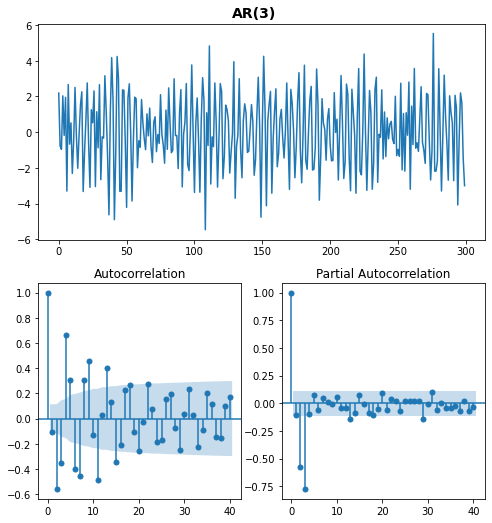

In [101]:
my_ts_plot(ar3, 'AR(3)')

* El decaimiento de la ACF es lento, pero no tanto como en el caso de la caminata aleatoria.
* La PACF decae en forma abrupta después del lag 3.

ACF: $\rho_j = \phi_1 \rho_{j-1}+\phi_2 \rho_{j-2}+\phi_3 \rho_{j-3}$

PACF: $\alpha_j = \phi_j$  si $j\leq 3$; 
$0$  si $j>3$

### MA(1)

$y_t = c - \theta_1 \varepsilon_{t-1} + \varepsilon_{t}$

$y_t =c +\theta(L)\varepsilon_{t}  = c +(1-\theta_1 L)\varepsilon_{t}$

In [102]:
#Simulación de un MA(1)
n = 300
ar = np.r_[1, 0]
ma = np.r_[1, -0.8]
ma1 = smtsa.arma_generate_sample(ar=ar, ma=ma, nsample=n)

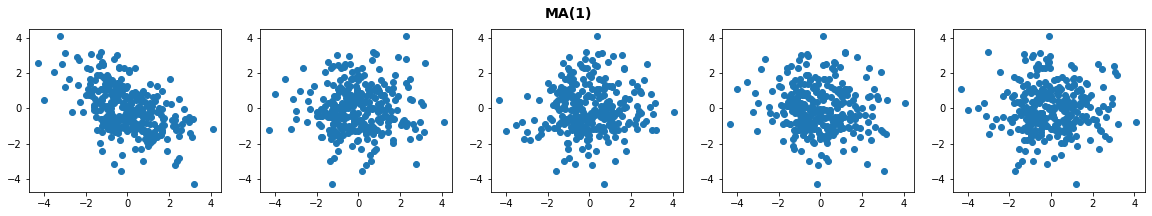

In [103]:
my_lag_plot(ma1, 'MA(1)')

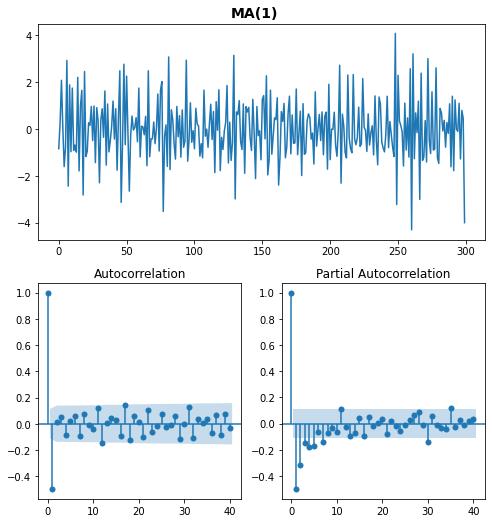

In [104]:
my_ts_plot(ma1, 'MA(1)')

* El decaimiento de la PACF es lento.
* La ACF decae en forma abrupta después del lag 1.

ACF: $\rho_1 = -\frac{\theta_1}{1 + \theta_1^2}$; 
$\rho_j = 0$  $\forall j\geq 2$

PACF: $\alpha_{jj} = -\frac{-\theta_1^j(1-\theta_1^2)}{1-\theta_1^{2(k+1)}}$


### MA(3)

$y_t = c - \theta_1 \varepsilon_{t-1} - \theta_2 \varepsilon_{t-2} -\theta_3 \varepsilon_{t-3}+ \varepsilon_{t}$

$y_t =c +\theta(L)\varepsilon_{t}  = c +(1-\theta_1 L - \theta_2 L^2 - ...- \theta_q L^q)\varepsilon_{t}$

In [105]:
#Simulación de un MA(3)
n = 300
ar = np.r_[1, 0]
ma = np.r_[1, 0.6, 0.7, 0.8]
ma3 = smtsa.arma_generate_sample(ar=ar, ma=ma, nsample=n)

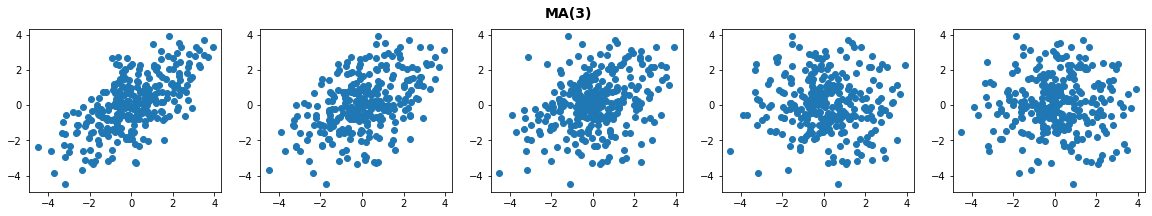

In [106]:
my_lag_plot(ma3, 'MA(3)')

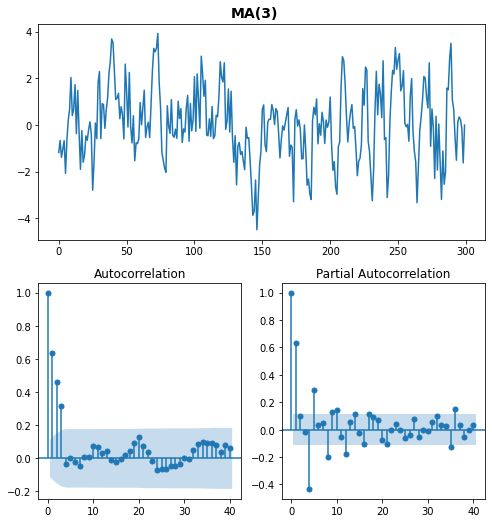

In [107]:
my_ts_plot(ma3, 'MA(3)')

* El decaimiento de la PACF es lento.
* La ACF decae en forma abrupta después del lag 3.

ACF: $\rho_j \neq 0$ $\forall j \leq q$; $\rho_j = 0$ $\forall j >q$

PACF: $\alpha_{jj}$ decrece suavemente

### ARMA(1,1)

$y_t = c +\phi_1 y_{t-1} - \theta_1 \varepsilon_{t-1} + \varepsilon_{t}$

$\phi(L) y_t =c +\theta(L)\varepsilon_{t}$

In [108]:
#Simulación de un ARMA(1,1)
n = 300
ar = np.r_[1, 0.8]
ma = np.r_[1, 0.6]
arma11 = smtsa.arma_generate_sample(ar=ar, ma=ma, nsample=n)

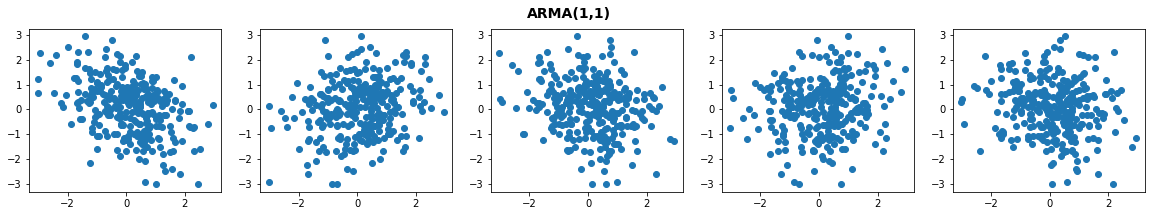

In [109]:
my_lag_plot(arma11, 'ARMA(1,1)')

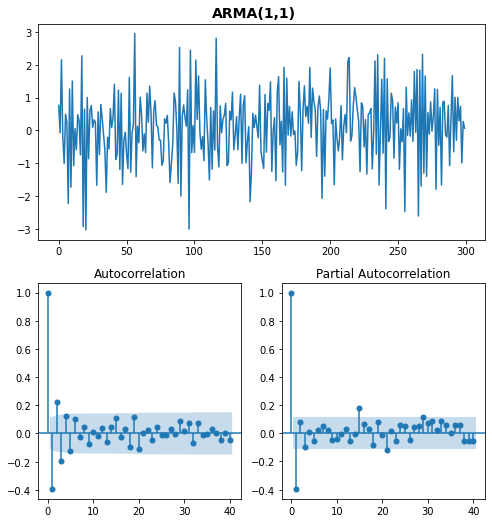

In [110]:
my_ts_plot(arma11, 'ARMA(1,1)')

* Los decaimientos de la ACF y PACF son lentos, aunque en algunos casos se puede ver decaimientos abruptos.



## ARIMA

$y_t$ es un proceso ARIMA(p,d,q) si al diferenciarlo $d$ veces se obtiene un ARMA(p,q)


$\phi(L)(1-L)^d y_t = c + \theta(L) \varepsilon_t$

In [111]:
# Simulación de un ARIMA(1,1,0)
arima110 = np.cumsum(ar1)

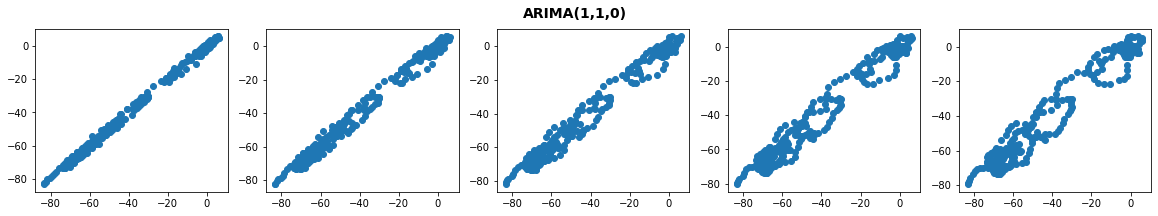

In [112]:
my_lag_plot(arima110, 'ARIMA(1,1,0)')

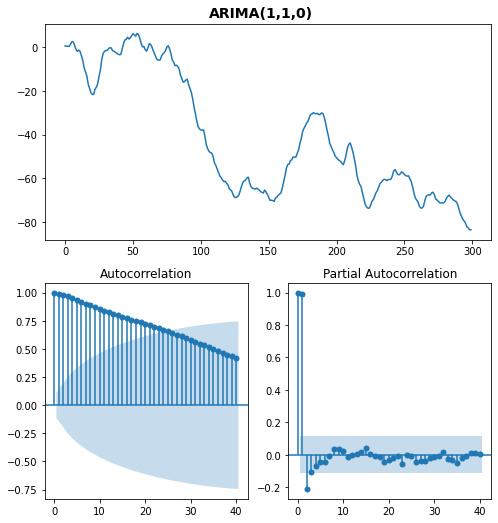

In [113]:
my_ts_plot(arima110, 'ARIMA(1,1,0)')

In [114]:
# Primera diferencia
arima110_dif = np.diff(arima110)

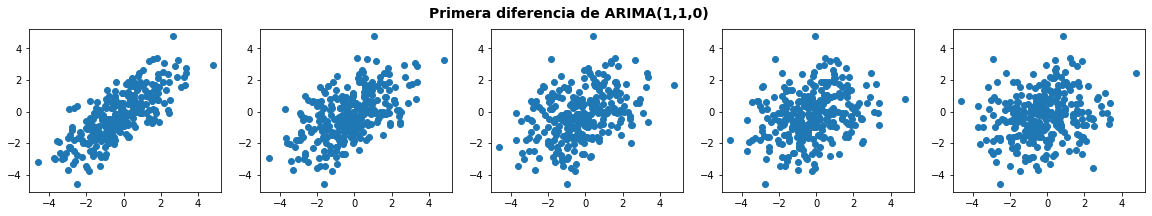

In [115]:
my_lag_plot(arima110_dif, 'Primera diferencia de ARIMA(1,1,0)')

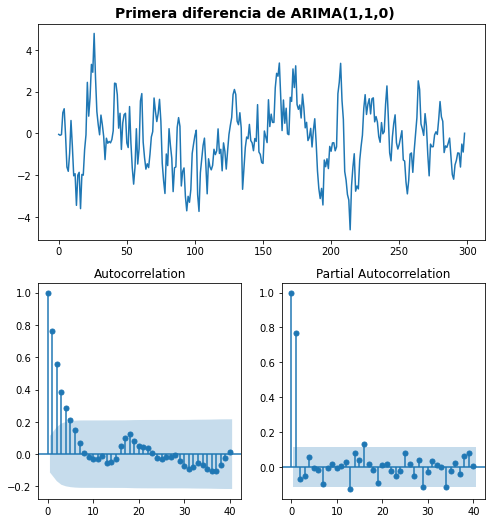

In [116]:
my_ts_plot(arima110_dif, 'Primera diferencia de ARIMA(1,1,0)')

Al tomar primera diferencia encontramos un proceso ARMA(1,0), por lo tanto el proceso estocástico original es ARIMA(1,1,0).

## Método de Box & Jenkins

Por medio de este procedimiento se busca encontrar el modelo ARIMA del cual proviene una serie de tiempo.
Sus etapas son:

* Transformación

* Identificación

* Estimación

* Diagnóstico

* Predicción

Trabajemos con la serie *sim4* del archivo *simulados_arima.csv*

In [117]:
df = pd.read_csv('simulados_arima.csv')
sim4 = df['sim4']

Grafiquemos

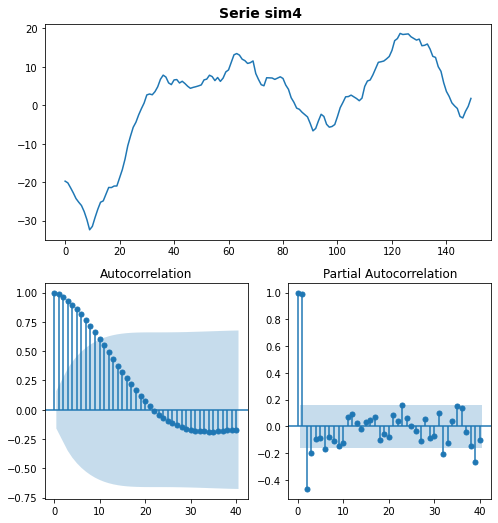

In [118]:
my_ts_plot(sim4, 'Serie sim4')

### Transformación

Se debe aplicar primera diferencia.

In [119]:
sim4_dif = np.diff(sim4)

### Identificación

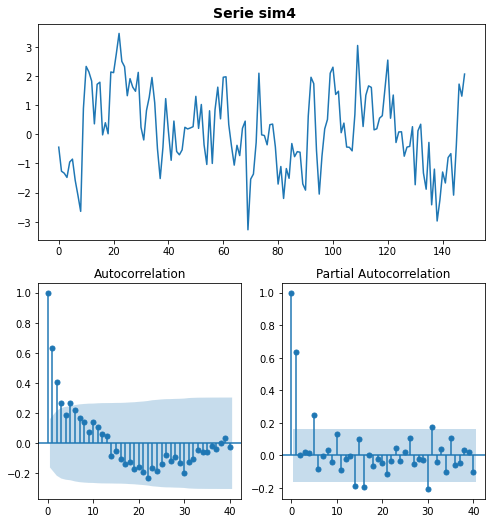

In [120]:
my_ts_plot(sim4_dif, 'Serie sim4')

### Estimación

In [121]:
model = sm.tsa.statespace.SARIMAX(sim4, trend='n', order=(1,1,0))
result = model.fit(disp=False)
residuos = result.resid
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                   sim4   No. Observations:                  150
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -218.603
Date:                Sat, 18 Sep 2021   AIC                            441.206
Time:                        10:20:26   BIC                            447.213
Sample:                             0   HQIC                           443.646
                                - 150                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6428      0.068      9.389      0.000       0.509       0.777
sigma2         1.0972      0.124      8.857      0.000       0.854       1.340
Ljung-Box (L1) (Q):                   0.00   Jarque-

Se pueden extraer los criterios de información

In [122]:
result.aic, result.bic, result.hqic

(441.205531703721, 447.2134243156119, 443.6464391530025)

y comparar contra un modelo alternativo, por ejemplo un ARIMA(5, 1, 0)

In [123]:
model_2 = sm.tsa.statespace.SARIMAX(sim4, trend='n', order=(1,1,0))
result_2 = model_2.fit(disp=False)
result_2.aic, result_2.bic, result_2.hqic

(441.205531703721, 447.2134243156119, 443.6464391530025)

Los criterios de información respaldan claramente al primer modelo.

### Diagnóstico
En la misma salida tenemos pruebas de no autocorrelación, homocedasticidad y normalidad. 
En los tres casos se no se rechazan las hipótesis nulas, por lo que hay indicios de que se cumplen los supuestos sobre los errores.

##### Autocorrelación

In [124]:
resulTestLB = sms.acorr_ljungbox(residuos, lags = 2)     
Nombres = ["Estadístico LB", "p-value del estadístico LB"]
pd.Series(resulTestLB, index = Nombres)

/home/adalisa/anaconda3/lib/python3.7/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


Estadístico LB                [0.04278192827107949, 0.20712764572580483]
p-value del estadístico LB      [0.8361364346871141, 0.9016184770330591]
dtype: object

##### Heterocedasticidad

In [125]:
resultARCHLM = smst.diagnostic.het_arch(residuos, maxlag=None)
Nombres = ['LM', 'p-value', 'F', 'p-value']
pd.Series(resultARCHLM, index = Nombres)

/home/adalisa/anaconda3/lib/python3.7/site-packages/statsmodels/stats/diagnostic.py:660: FutureWarning: The default value of nlags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setmaxlags or period to silence this warning.
  FutureWarning)


LM         8.238391
p-value    0.876540
F          0.557313
p-value    0.892931
dtype: float64

#### Normalidad

In [126]:
from scipy.stats import shapiro           
resultadosTestSW = shapiro(residuos)
Nombres = ["Estadístico SW", "p-value"]
pd.Series(resultadosTestSW, index = Nombres)

Estadístico SW    5.210761e-01
p-value           3.949894e-20
dtype: float64

Se confirma el cumplimiento de los supuestos

### Pronóstico

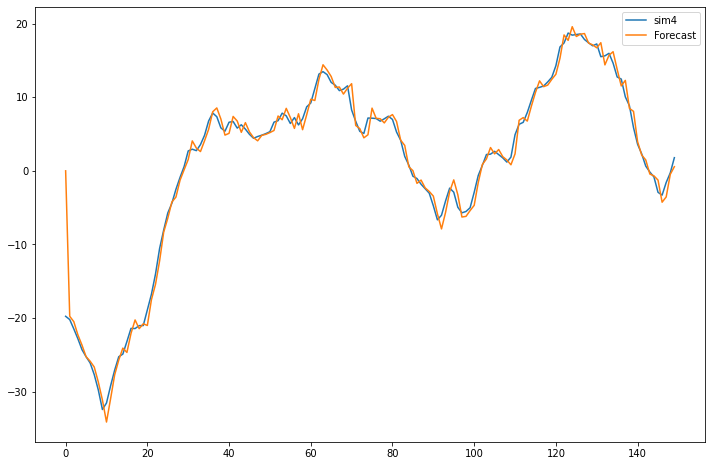

In [127]:
data= pd.DataFrame()
data['sim4'] = sim4
data['Forecast'] = result.predict(start = 0, end = 149, dynamic= False)  
data[['sim4', 'Forecast']].plot(figsize=(12, 8))
plt.show()

## SARIMA

El modelo se puede escribir como


$\Phi_P(L^s) \phi_p(L) (1-L^s)^D (1-L)^d y_t = c + \Theta_Q (L^s) \theta_q(L)\varepsilon_t$


Donde:

$\Phi_P(L^s) = (1 - \Phi_1 L^s - \Phi_2 L^{2s} - ...- \Phi_P L^{Ps})$

$\phi_p(L) = (1 - \phi_1 L - \phi_2 L^{2} - ...- \phi_p L^{p})$

$(1-L^s)^D = \Delta_s^D$

$(1-L)^d = \Delta^d$

$\Theta_Q(L^s) = (1 - \Theta_1 L^s - \Theta_2 L^{2s} - ...- \Theta_Q L^{Qs})$

$\theta_q(L) = (1 - \theta_1 L - \theta_2 L^{2} - ...- \theta_q L^{q})$

In [134]:
df = pd.read_csv('Exports_Merchandise.csv')
#df['Month'] = pd.to_datetime(df['Month'], format = '%Y-%m')#.dt.strftime('%Y-%m')
#df = df.set_index('Month')


expo_arg = df['Argentina']

In [135]:
def my_ts_plot_2(serie, titulo, displayLags=30):
    fig = plt.figure()
    fig.set_figheight(8)
    fig.set_figwidth(8)

    fig.suptitle(titulo, fontsize = 14, fontweight = "bold")
    plt.subplots_adjust(top = 0.95) 
    ax0 = plt.subplot2grid(shape=(2, 2), loc=(0, 0), colspan=2)
    ax1 = plt.subplot2grid(shape=(2, 2), loc=(1, 0), colspan=1)
    ax2 = plt.subplot2grid(shape=(2, 2), loc=(1, 1), rowspan=1)

    ax0.plot(serie)
    sm.graphics.tsa.plot_acf(serie, lags=displayLags, ax=ax1)
    sm.graphics.tsa.plot_pacf(serie, lags=displayLags, ax=ax2)

    plt.show()

ValueError: could not convert string to float: '6028,7'

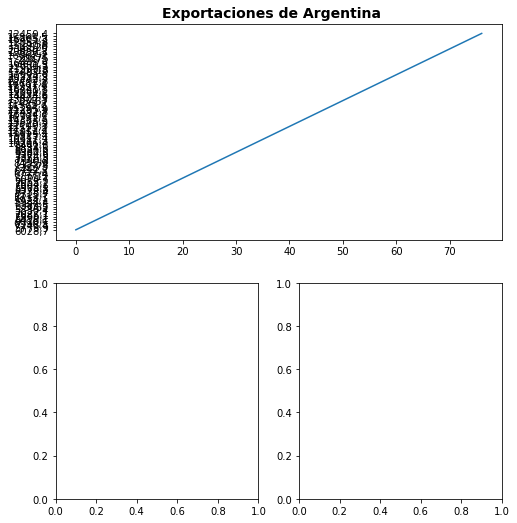

In [136]:
my_ts_plot_2(expo_arg, 'Exportaciones de Argentina')

### Transformación

In [ ]:
model = sm.tsa.statespace.SARIMAX(expo_arg, trend='n', order=(0,0,0),seasonal_order=(0,1,0,4))
result = model.fit(disp=False)
residuos = result.resid
my_ts_plot_2(residuos, 'Residuos')

### Identificación

In [ ]:
model = sm.tsa.statespace.SARIMAX(expo_arg, trend='n', order=(0,0,0),seasonal_order=(1,1,0,4))
result = model.fit(disp=False)
residuos = result.resid
my_ts_plot_2(residuos, 'Residuos')

In [ ]:
model = sm.tsa.statespace.SARIMAX(expo_arg, trend='n', order=(1,0,0),seasonal_order=(1,1,0,4))
result = model.fit(disp=False)
residuos = result.resid
my_ts_plot_2(residuos, 'Residuos')

In [ ]:
model = sm.tsa.statespace.SARIMAX(expo_arg, trend='n', order=(1,0,0),seasonal_order=(1,1,1,4))
result = model.fit(disp=False)
residuos = result.resid
my_ts_plot_2(residuos, 'Residuos')

### Estimación

In [ ]:
print(result.summary())

In [ ]:
result.aic, result.bic, result.hqic

### Diagnóstico
En la misma salida tenemos pruebas de no autocorrelación, homocedasticidad y normalidad. 
No hay normalidad ni homocedasticidad.

##### Autocorrelación

In [137]:
resulTestLB = sms.acorr_ljungbox(residuos, lags = 2)     
Nombres = ["Estadístico LB", "p-value del estadístico LB"]
pd.Series(resulTestLB, index = Nombres)

Estadístico LB                [0.04278192827107949, 0.20712764572580483]
p-value del estadístico LB      [0.8361364346871141, 0.9016184770330591]
dtype: object

##### Heterocedasticidad

In [138]:
resultARCHLM = smst.diagnostic.het_arch(residuos, maxlag=None)
Nombres = ['LM', 'p-value', 'F', 'p-value']
pd.Series(resultARCHLM, index = Nombres)

LM         8.238391
p-value    0.876540
F          0.557313
p-value    0.892931
dtype: float64

#### Normalidad

In [139]:
from scipy.stats import shapiro           
resultadosTestSW = shapiro(residuos)
Nombres = ["Estadístico SW", "p-value"]
pd.Series(resultadosTestSW, index = Nombres)

Estadístico SW    5.210761e-01
p-value           3.949894e-20
dtype: float64

Se confirma que no hay normalidad ni homocedasticidad.

### Pronóstico

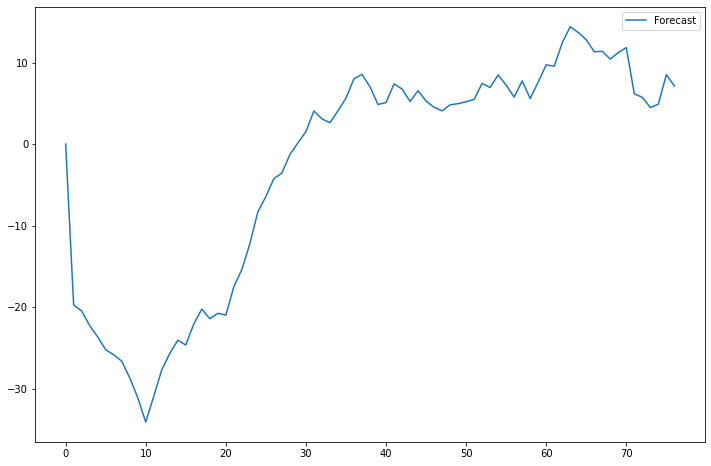

In [140]:
data= pd.DataFrame()
data['Exportaciones'] = expo_arg
data['Forecast'] = result.predict(start = 0, end = 149, dynamic= False)  
data[['Exportaciones', 'Forecast']].plot(figsize=(12, 8))
plt.show()